# CNN-XGBoost and CNN-PCA-KNN to train on Chest X-ray Images for Fibrosis Detection

> Indented block


This notebook was created using Google Colab. Part 1 can be skipped by using the link in Part 2 to download the 2000 images that Part 1 is used to create.

The .csv file for the 2000 samples can be found [here](https://drive.google.com/file/d/1kzxaX1cP3zip1nSY5svB2Rx7sTZWUKR8/view?usp=sharing). The 2000 images can be found [here](https://drive.google.com/open?id=1Xy72xG0Y_VnngZBl4RuFQl4IVHxtHx3R) to skip Part 1 step.

##Imports/Setup

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copy
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.densenet import DenseNet121
#from keras.optimizers import RMSprop, SGD, Adam
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation,Dense
from xgboost import XGBClassifier
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import max_norm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support , confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [ ]:
root_path = '/content/drive/My Drive/CS235/'
csv_path = root_path + 'Fibrosis_Sampled2000.csv'
img_folder_path = '/content/2000images/'
NUM_IMAGES = 2000
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_CHANNELS = 3
batch_size = 16

In [ ]:
#mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

## Part 1: Chest X-Ray Dataset from Kaggle: Retrieving, Sampling, Saving to Google Drive
This section is solely for retrieving the full data set and sampling 2000 per  the .csv file. The samples are saved in Google Drive so that it can be copied into each new runtime environments as necessary.

This part can be skipped as the work has been done and uploaded for sharing on Google Drive.

To only run this once, the 2000 images will be matched to the .csv and placed into Google Drive since saving all of the images (42gb) will be too big for Google Drive standard size (15gb), and there is no easy way to reference the local drive with Google Colab for each image.


In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
#to upload kaggle file to access kaggle chest x-ray dataset; need kaggle acct
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d nih-chest-xrays/data

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip -q data.zip

In [ ]:
!mkdir /content/allimages
!mv /content/images_001/images/* /content/allimages
!mv /content/images_002/images/* /content/allimages
!mv /content/images_003/images/* /content/allimages
!mv /content/images_004/images/* /content/allimages
!mv /content/images_005/images/* /content/allimages
!mv /content/images_006/images/* /content/allimages
!mv /content/images_007/images/* /content/allimages
!mv /content/images_008/images/* /content/allimages
!mv /content/images_009/images/* /content/allimages
!mv /content/images_010/images/* /content/allimages
!mv /content/images_011/images/* /content/allimages
!mv /content/images_012/images/* /content/allimages

In [ ]:
!rm data.zip
!rm -R images_001
!rm -R images_002
!rm -R images_003
!rm -R images_004
!rm -R images_005
!rm -R images_006
!rm -R images_007
!rm -R images_008
!rm -R images_009
!rm -R images_010
!rm -R images_011
!rm -R images_012

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls 'drive/My Drive/CS235/'


2000images/  Fibrosis_Sampled2000.csv


In [ ]:
data = pd.read_csv(csv_path)
data

,filename,fibrosis,age,gender,viewPosition,imgWidth,imgHeight,xPixelSpacing,yPixelSpacing
0,00000003_006.png,0,79,F,PA,2992,2991,0.143000,0.143000
1,00000020_002.png,1,48,M,PA,2414,2991,0.143000,0.143000
2,00000022_001.png,1,49,M,PA,2500,2048,0.168000,0.168000
3,00000032_030.png,0,55,F,AP,2500,2048,0.168000,0.168000
4,00000048_000.png,0,46,F,PA,2834,2641,0.143000,0.143000
...,...,...,...,...,...,...,...,...,...
1995,00030539_000.png,0,27,M,PA,2021,2021,0.194311,0.194311
1996,00030573_004.png,0,26,M,AP,3056,2544,0.139000,0.139000
1997,00030662_000.png,1,49,F,PA,1940,2021,0.194311,0.194311
1998,00030702_000.png,1,65,M,PA,2021,2021,0.194311,0.194311


In [ ]:
!mkdir /content/2000images
src = "/content/allimages/"
dst = "/content/2000images/"
for i in data.filename:
    src_img = src + i
    copy(src_img, dst)

FileNotFoundError: ignored

In [ ]:
#move 2000 images to Google Drive for permanent storage instead of runtime tmp
!mkdir '/content/drive/My Drive/CS235/2000images'
!cp /content/2000images/* '/content/drive/My Drive/CS235/2000images'

mkdir: cannot create directory ‘/content/drive/My Drive/CS235/2000images’: File exists
cp: cannot stat '/content/2000images/*': No such file or directory


In [ ]:
#verify 2000 images as expected
!ls -F |grep -v / | wc -l

2000


## Part 2: Retrieve 2000 images from Google Drive
Copies the 2000 images from Google Drive into the current runtime environment.

The images can be found [here](https://drive.google.com/open?id=1Xy72xG0Y_VnngZBl4RuFQl4IVHxtHx3R) so you don't have to run Part 1. Ensure that you download the images to your Google Drive if you want to run on Google Colab (update the directory and variables in this part and Imports/Setup as necessary).

In [ ]:
!mkdir '/content/2000images'
!cp '/content/drive/My Drive/CS235/2000images/'* /content/2000images/

In [ ]:
#verify 2000 images as expected
%cd '/content/2000images'
!ls -F |grep -v / | wc -l

/content/2000images
2000


##Part 3: Split Dataset to Training, Validation, and Verification
Code was made with assistance from this [website](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part3.ipynb#scrollTo=a38rB3lyedcB). All of the data is split to 70% training, 15% test, and 15% validation.

In [ ]:
test_percent = 0.2
test_val_percent = 0.5

In [ ]:
data = pd.read_csv(csv_path)
target_labels = data.fibrosis
img_paths = [None] * NUM_IMAGES
ptr = 0

#create array of full paths for the images
for i in data.filename:
  img_paths[ptr] = img_folder_path + i
  ptr += 1

In [ ]:
type(data.fibrosis)

pandas.core.series.Series

In [ ]:
#set an array of all the image samples
train_data = np.array([img_to_array(
                            load_img(path,
                                     target_size=(IMG_WIDTH, IMG_HEIGHT))
                       ) for path in img_paths
                      ]).astype('float32')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_data,
                                                    target_labels,
                                                    test_size=test_percent,
                                                    stratify=np.array(
                                                        target_labels),
                                                    random_state=None)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test,
                                                test_size=test_val_percent,
                                                stratify=np.array(y_test),
                                                random_state=None)

In [ ]:
x_train.shape, x_test.shape, x_val.shape
target_labels.value_counts().to_dict()

{0: 1000, 1: 1000}

### Part 3.1: Data Augmentation
Due to prior attempted runs having poor validation accuracy (<55%), the training data is augmented in this section.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = False)
train_generator = train_datagen.flow(x_train, y_train, shuffle=False,
                                     batch_size=batch_size, seed=1)

val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val, shuffle=False,
                                   batch_size=batch_size, seed=1)

## Part 4: Training: Transfer Learning with InceptionV3
Code was made with assistance from this [website](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part3.ipynb#scrollTo=a38rB3lyedcB).

In [ ]:
model = InceptionV3(input_shape=(IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS),
                    include_top = False, weights='imagenet')

In [ ]:
num_layers = len(model.layers)
num_layers

19

In [ ]:
out = model.output
out = layers.Flatten()(out)
out = layers.Dense(1024, activation='relu', kernel_constraint=max_norm(3))(out)
out = layers.Dropout(0.2)(out)
out = layers.Dense(64, activation='relu',kernel_constraint=max_norm(3))(out)
out = layers.Dropout(0.2)(out)
out = layers.Dense(1, activation='sigmoid')(out)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# Configuration/Compilation
model = Model(model.input, out)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.000005),
              metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size



history = model.fit_generator(train_generator,
      steps_per_epoch=train_steps_per_epoch,
      validation_data=val_generator,
      validation_steps=val_steps_per_epoch,
      epochs=40,
      verbose=1
      )


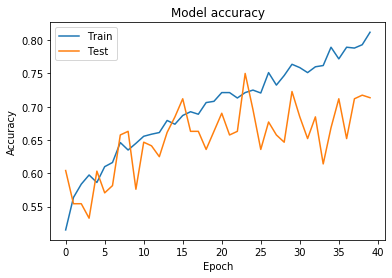

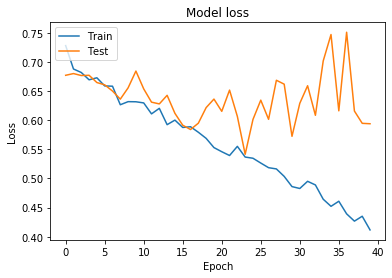

In [ ]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Part 5: PCA on CNN feature extractor and KNN




In this session we get the output of the CNN feature extractor part and then start processing it.

In [ ]:
y_inspection_pred = model.predict(x_test, verbose=0)

In [ ]:
layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train)
intermediate_output_x_test = intermediate_layer_model.predict(x_test)


In [ ]:
intermediate_output_x_test = intermediate_layer_model.predict(x_test)

In this part, we do a PCA to diminish the big number of features that come out from the CNN feature extractor. It will be reduced from thousands to 199.

In [ ]:
pca = PCA(n_components=199)
pca_intermediate_output = pca.fit_transform(intermediate_output)
pca_intermediate_output_x_test = pca.fit_transform(intermediate_output_x_test)



Also we do a K nearest neighbour classifier on the PCA output.

In [ ]:
KNNClassifier = KNeighborsClassifier(3)
KNNClassifier.fit(pca_intermediate_output, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
y_pca_pred = KNNClassifier.predict(pca_intermediate_output_x_test)


Here is the final calculation for figuring out our goodness of our model.

In [ ]:
accuracy = accuracy_score(y_test, y_pca_pred.round())
print(accuracy)
print(confusion_matrix(y_test, y_pca_pred.round()))
print(precision_recall_fscore_support(y_test, y_pca_pred.round(), average='macro'))


0.51
[[50 50]
 [48 52]]
(0.5100040016006402, 0.51, 0.50995099509951, None)


##Part 6: XGBoost on CNN feature extractor

> In this part we use XGBoost classifier which is an ensemble learning method. We use this method on the output data of CNN extractor part.



In [ ]:
xgbClassifier = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.001,
                max_depth = 10, alpha = 10, n_estimators = 200)
xgbClassifier.fit(intermediate_output, y_train)

[02:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [ ]:
y_pred = xgbClassifier.predict(intermediate_output_x_test)

NameError: ignored

In [ ]:

accuracy = accuracy_score(y_test, y_pred.round())
accuracy

In [ ]:
confusion_matrix(y_test, y_pred.round())

array([[66, 34],
       [38, 62]])

In [ ]:
intermediate_output.shape

(1600, 73728)